In [4]:
import sys 
import requests
import pandas as pd
import numpy as np
from pathlib import Path 
from PIL import Image
from skimage import io
import shutil

print(pd.__version__)
print(np.__version__)
!python -V

dir_meta = Path('meta')
dir_meta.mkdir(exist_ok=True, parents=True)


1.3.5
1.21.5
Python 3.7.11


## Findout Problemed imgs

- Check img size in downloaded/jpg100.txt
    - txt檔來源為windows cmd所得，需要先做比較麻煩的若干轉換
    - use notepad++ convert encoding to 'utf-8'

In [36]:

# 'jpg100.txt' from windows cmd
# df_jpg100 = pd.read_csv('downloaded/jpg100.txt',
#                         header=None,
#                         # sep=''
#                         names=['img']
#                         )
# df_jpg100_raw = df_jpg100.query('img.str.contains("-a----")')
# df_jpg100 = df_jpg100_raw.query('img.str.contains("-a----")').reset_index(drop=True)
# del df_jpg100_raw

# df_tmp = df_jpg100.img.str.strip().str.split(' ')
# df_jpg100['Filename'] = df_tmp.apply(lambda x : x[-1].replace('.jpg', ''))
# df_jpg100['Size'] = df_tmp.apply(lambda x : x[-2]).astype('uint64')

# del df_tmp

# df_jpg100 = df_jpg100[['Filename','Size']]
# df_jpg100

- Find out problemed size of img
    -  Size==919

In [81]:
size_919 = df_jpg100.query('Size==919')
print(f'Problemed img with size == "919" :{len(size_919):4,d}')
# size_919.to_csv('meta/problemed_size919.csv')

Problemed img with size == "919" :439,033


- Find out problemed size of img
    - condition1 : count>1
    - size <= 10,000

In [73]:
# Find out problemed size of img
# condition1 : count>1
# size <= 10,00
small_size = (df_jpg100.query('Size<=1000 and Size!=919')
              .sort_values(by=['Size'])
              )

# small_size.duplicated(subset=['Size'] ,keep=False)
small_size = small_size.query("Size.duplicated(keep=False)")

print(f'Size < 10kb : {len(small_size):4,d}' )

# small_size.to_csv('meta/problemed_size_under1000.csv')
print(small_size.Size.unique())
# small_size

Size < 10kb :   45
[ 72  73 176 226]


In [45]:
df_problemed = (df_jpg100.query('Size<=1000')
              .sort_values(by=['Size'])
              .reset_index(drop=True)
              )
# df_problemed.to_csv('meta/problemed.csv')
# df_problemed.query('Filename.duplicated()')
df_problemed.duplicated(subset=['Filename']).all()

False

### 確認目前已重新下載的檔案
- downloaded\Accipitridae.txt

In [47]:
df_reloaded = pd.read_csv('downloaded/Accipitridae.txt', skiprows=1, header=None, names=['File'])

tmp = df_reloaded.File.str.split('esslab')
tmp = (tmp.apply(lambda x : x[-1])
       .str.strip(' ')
       .str.split(' ')
       )
df_reloaded['Filename'] = tmp.apply(lambda x : x[-1].replace('.jpg', ''))
df_reloaded['Size'] = tmp.apply(lambda x : x[0]).astype('uint64')
 
df_reloaded = df_reloaded[['Filename','Size']]

del tmp
df_reloaded

,Filename,Size
0,Accipiter_bicolor_3_113244551,39763
1,Accipiter_bicolor_3_113244561,80910
2,Accipiter_bicolor_3_113244571,157283
3,Accipiter_bicolor_3_120354591,207008
4,Accipiter_bicolor_3_120354611,214986
...,...,...
139176,Spizaetus_ornatus_0_99100801,73810
139177,Spizaetus_ornatus_0_99100851,69760
139178,Spizaetus_ornatus_0_99100891,90851
139179,Spizaetus_ornatus_0_99278801,73916


In [137]:
df_reloaded_s = df_reloaded.query('Size<2000').query("Size.duplicated(keep=False)")

print(df_reloaded_s.Size.unique())
df_reloaded_s.sort_values(by='Size')


[ 73  72 282]


,Filename,Size
139022,Spizaetus_ornatus_0_78930691,72
112058,Melierax_canorus_0_27826441,72
112097,Melierax_canorus_0_51867131,72
112106,Melierax_canorus_0_60980011,72
112107,Melierax_canorus_0_60980021,72
...,...,...
51644,Buteogallus_anthracinus_0_264021221,73
49573,Buteogallus_anthracinus_0_204055041,73
86427,Buteo_lineatus_0_234100221,73
103426,Geranoaetus_albicaudatus_0_199744901,282


- 檔案大小72, 73應該都是無法抓到圖檔的大小
    - 72 :
        - {"errorMsg":"78930691 not on record","errorCode":"asset_id_not_found"}
    - 73 : 
        - {"errorMsg":"234100221 not on record","errorCode":"asset_id_not_found"}
    - 282 :
        - <?xml version="1.0" encoding="UTF-8"?><Error><Code>InternalError</Code><Message>We encountered an internal error. Please try again.</Message><RequestId>P77E3GMEVNRD4HP6</RequestId><HostId>EvA61XRubY7/F5CcNCj2PaIohRXmAz+KXUgwKSPLyvMiC6/v625fr/B2J7B28tbG3yU+aruM/LQ=</HostId></Error>


- File need reloaded
    - problemed - reloed
    - problemed == size919 + size_under1000 

In [48]:
df_problemed  = df_reloaded.merge(df_problemed,on='Filename', how='right').query('Size_x.isnull()')
df_problemed['ML Catalog Number'] = df_problemed.Filename.apply(lambda x: x.split('_')[-1]).values
df_problemed['SciName'] = df_problemed.Filename.str.extract(r'([\w]+_[a-z]+_[\d]{1,3})')
print('Number of sp. : ',df_problemed.SciName.nunique())

df_problemed = df_problemed.drop(columns=['Size_bx']).rename(columns={'Size_y':'Size'})
df_problemed

Number of sp. :  6028


,Filename,Size,ML Catalog Number,SciName
0,Iole_indica_0_44375611,72,44375611,Iole_indica_0
1,Eumyias_albicaudatus_0_44374961,72,44374961,Eumyias_albicaudatus_0
2,Ficedula_nigrorufa_0_44375001,72,44375001,Ficedula_nigrorufa_0
3,Turdus_simillimus_0_44375031,72,44375031,Turdus_simillimus_0
4,Gerygone_olivacea_0_264022171,73,264022171,Gerygone_olivacea_0
...,...,...,...,...
439073,Treron_fulvicollis_0_56013561,919,56013561,Treron_fulvicollis_0
439074,Treron_fulvicollis_0_56013541,919,56013541,Treron_fulvicollis_0
439075,Treron_fulvicollis_0_56013511,919,56013511,Treron_fulvicollis_0
439076,Treron_fulvicollis_0_55699571,919,55699571,Treron_fulvicollis_0


- get Family by Sciname

In [50]:
# get Family by Sciname
dir_csv = Path('downloaded/csv')
fam_sp = [ f'{path.parent.name},{path.stem}' for path in list(dir_csv.glob('**/*.csv'))]

df_fam_sp = pd.DataFrame(fam_sp, columns=['Path'])
df_fam_sp['Family'] = df_fam_sp.Path.apply(lambda x: x.split(',')[0]).astype((str))
df_fam_sp['SciName'] = df_fam_sp.Path.apply(lambda x: x.split(',')[1]).astype((str))
df_fam_sp= df_fam_sp[['Family', 'SciName']]
df_fam_sp

df_problemed = df_problemed.merge(df_fam_sp, on='SciName', how='left') 
df_problemed = df_problemed.sort_values(by=['Family','SciName','ML Catalog Number']).reset_index(drop=True)
df_problemed = df_problemed[['Family', 'SciName','ML Catalog Number','Filename', 'Size']]
df_problemed =  df_problemed.drop_duplicates(subset=['Filename']).reset_index(drop=True)

df_problemed.to_csv('meta/problemed.csv')
df_problemed



,Family,SciName,ML Catalog Number,Filename,Size
0,Acanthizidae,Gerygone_olivacea_0,264022171,Gerygone_olivacea_0_264022171,73
1,Acanthizidae,Gerygone_olivacea_0,264022171,Gerygone_olivacea_0_264022171,73
2,Accipitridae,Accipiter_albogularis_0,92312611,Accipiter_albogularis_0_92312611,919
3,Accipitridae,Accipiter_albogularis_0,92312611,Accipiter_albogularis_0_92312611,919
4,Accipitridae,Accipiter_albogularis_0,47701701,Accipiter_albogularis_0_47701701,919
...,...,...,...,...,...
576250,Viduidae,Vidua_wilsoni_0,184097481,Vidua_wilsoni_0_184097481,919
576251,Viduidae,Vidua_wilsoni_0,184095911,Vidua_wilsoni_0_184095911,919
576252,Viduidae,Vidua_wilsoni_0,178658461,Vidua_wilsoni_0_178658461,919
576253,Viduidae,Vidua_wilsoni_0,84354761,Vidua_wilsoni_0_84354761,919


# Checking Data updated 
- 'downloaded\jpg100_1M.txt'

In [9]:
# df_jpg100 = pd.read_csv('meta/jpg100_1M.txt',
#                         usecols=[4,9],
#                         names=['Size', 'Path'],
#                         sep=' ',
#                         header=None 
#                         )
# df_jpg100 = df_jpg100.query('~Path.str.contains("checkpoint")').reset_index(drop=True)
# df_jpg100

,Size,Path
0,162891,jpg100_1M/Acanthisittidae/Acanthisitta_chloris...
1,296210,jpg100_1M/Acanthisittidae/Acanthisitta_chloris...
2,124934,jpg100_1M/Acanthisittidae/Acanthisitta_chloris...
3,294646,jpg100_1M/Acanthisittidae/Xenicus_gilviventris...
4,230262,jpg100_1M/Acanthisittidae/Xenicus_gilviventris...
...,...,...
1207165,211764,jpg100_1M/Zosteropidae/Zosterops_maderaspatanu...
1207166,109798,jpg100_1M/Zosteropidae/Zosterops_lateralis_0_6...
1207167,206092,jpg100_1M/Zosteropidae/Zosterops_lateralis_0_1...
1207168,165973,jpg100_1M/Zosteropidae/Zosterops_somadikartai_...


In [10]:
# def get_family(s:pd.Series):
#     return Path(s).parent.name
# def get_basename(s:pd.Series):
#     return Path(s).stem

# df_jpg100['Family'] = df_jpg100.Path.apply(get_family)
# df_jpg100['Filename'] = df_jpg100.Path.apply(get_basename)

In [11]:
# df_jpg100['ML Catalog Number'] = df_jpg100.Filename.apply(lambda x: x.split('_')[-1]).astype('uint32')
# df_jpg100['SciName'] = df_jpg100.Filename.str.extract(r'([\w]+_[a-z]+_[\d]{1,3})')
# # convert byte to kb
# df_jpg100['Size'] = df_jpg100.Size.apply(lambda x: round(x/1024,2))                     

# df_jpg100 = df_jpg100[['Family', 'SciName','ML Catalog Number','Filename', 'Size']]

# df_jpg100 = df_jpg100.sort_values(by=['Family','SciName','ML Catalog Number']).reset_index(drop=True)

# df_jpg100 

,Family,SciName,ML Catalog Number,Filename,Size
0,Acanthisittidae,Acanthisitta_chloris_0,22413261,Acanthisitta_chloris_0_22413261,61.48
1,Acanthisittidae,Acanthisitta_chloris_0,22413271,Acanthisitta_chloris_0_22413271,68.64
2,Acanthisittidae,Acanthisitta_chloris_0,30352591,Acanthisitta_chloris_0_30352591,132.18
3,Acanthisittidae,Acanthisitta_chloris_0,40629251,Acanthisitta_chloris_0_40629251,176.57
4,Acanthisittidae,Acanthisitta_chloris_0,41060091,Acanthisitta_chloris_0_41060091,165.23
...,...,...,...,...,...
1207165,Zosteropidae,Zosterornis_whiteheadi_0,219727771,Zosterornis_whiteheadi_0_219727771,310.95
1207166,Zosteropidae,Zosterornis_whiteheadi_0,219727781,Zosterornis_whiteheadi_0_219727781,349.39
1207167,Zosteropidae,Zosterornis_whiteheadi_0,219727791,Zosterornis_whiteheadi_0_219727791,368.17
1207168,Zosteropidae,Zosterornis_whiteheadi_0,219727801,Zosterornis_whiteheadi_0_219727801,324.02


In [3]:
# df_jpg100.to_csv('meta/jpg100_1M.csv') 
df_jpg100 = pd.read_csv('meta/jpg100_1M.csv', index_col=0)


In [14]:
df_jpg100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1207170 entries, 0 to 1207169
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Family             1207170 non-null  object 
 1   SciName            1207170 non-null  object 
 2   ML Catalog Number  1207170 non-null  int64  
 3   Filename           1207170 non-null  object 
 4   Size               1207170 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 55.3+ MB


In [29]:
df_jpg100.describe()

,ML Catalog Number,Size
count,1.207170e+06,1.207170e+06
mean,1.621358e+08,1.915763e+02
std,6.817397e+07,1.813148e+02
min,7.006500e+05,1.220000e+00
25%,1.100026e+08,1.213600e+02
50%,1.763430e+08,1.727700e+02
75%,2.135906e+08,2.301100e+02
max,2.644940e+08,9.048920e+03


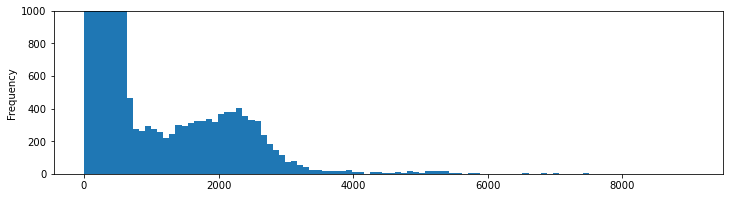

In [31]:
# 檢視影像size分布
df_jpg100.Size.plot.hist(figsize=(12,3),bins=100, ylim=(0,1000));

## 篩選出疑似有問題的小檔案


In [98]:
size_5k = df_jpg100.query('Size<=5')
print(len(size_5k))

size_5k.to_csv('meta/size_5k.csv')

size_5k_10k = df_jpg100.query('Size>5 and Size<=10')
size_5k_10k.to_csv('meta/size_5k_10k.csv')
size_10k =  df_jpg100.query('Size>5000 and Size<=10000')
print(len(size_10k))

size_10k_30k =  df_jpg100.query('Size>10 and Size<=30')
size_50k =  df_jpg100.query('Size(kb)<=50')
print(len(size_50k))

295
1107
14525


In [ ]:
size_5k.groupby(['Family']).SciName.count()

### 複製疑似問題小檔案到獨立資料夾

In [109]:
dir_problemed = Path('Problemed_imgs')
dir_jpg100_1M = Path('downloaded/jpg100_1M')

dir_size_5k = dir_problemed.joinpath('size_5k')
dir_size_5k.mkdir(exist_ok=True, parents=True)
dir_size_5k_10k = dir_problemed.joinpath('size_5k_10k')
dir_size_5k_10k.mkdir(exist_ok=True, parents=True)

In [111]:

size_5k = pd.read_csv('meta/size_5k.csv', index_col=0)
size_5k_10k = pd.read_csv('meta/size_5k_10k.csv', index_col=0)

df = pd.concat([size_5k,size_5k_10k])
df


,Family,SciName,ML Catalog Number,Filename,Size
7765,Accipitridae,Accipiter_rufitorques_0,118117961,Accipiter_rufitorques_0_118117961,2782
8287,Accipitridae,Accipiter_soloensis_0,125192801,Accipiter_soloensis_0_125192801,4109
8602,Accipitridae,Accipiter_soloensis_0,218421771,Accipiter_soloensis_0_218421771,4035
10775,Accipitridae,Aquila_adalberti_0,25928561,Aquila_adalberti_0_25928561,4355
10776,Accipitridae,Aquila_adalberti_0,25928571,Aquila_adalberti_0_25928571,4355
...,...,...,...,...,...
1145755,Tyrannidae,Attila_spadiceus_1,62144801,Attila_spadiceus_1_62144801,6625
1197779,Vireonidae,Vireo_cassinii_3,36002551,Vireo_cassinii_3_36002551,5200
1197780,Vireonidae,Vireo_cassinii_3,36002631,Vireo_cassinii_3_36002631,7971
1201559,Vireonidae,Vireo_solitarius_1,36002551,Vireo_solitarius_1_36002551,5200


In [ ]:
for i,  (idx, rows) in enumerate(df.iterrows()):
    
    family, sp, mlcn, filename, size = rows
    print(i, idx, filename, end='\r')
    
    dir_save = dir_size_5k if size<=5000 else dir_size_5k_10k
    
    
    load_path = dir_jpg100_1M.joinpath(family, filename + '.jpg') 
    save_path = dir_save.joinpath( filename + '.jpg') 
    shutil.copyfile(load_path, save_path)

### 小結
- 均是縮圖小檔，無問題資料
- 圖片本身仍帶有可辨識物種類群訊息

## 類群統計數據

### 統計小結
- 共249科、16403種
    - 每科物種數統計:中位數:17 、平均111
    - 有34科僅有1個物種
- 科統計
    - 影像數量(樣本數)：中位數:1140 、平均4848 
- 物種統計
    - 影像數量(樣本數)：中位數:83 、平均235
    - 有466個物種僅有1張影像　

#### Count Sp by Family 

In [117]:
df_count_F_SP = (df_jpg100.groupby(['Family', 'SciName']).count()
                .reset_index()[['Family', 'SciName']]
                .groupby(['Family']).count()
                .sort_values(by=['SciName'])
                )
df_count_F_SP.describe()

,SciName
count,249.000000
mean,65.875502
std,111.472243
min,1.000000
25%,3.000000
50%,17.000000
75%,71.000000
max,663.000000


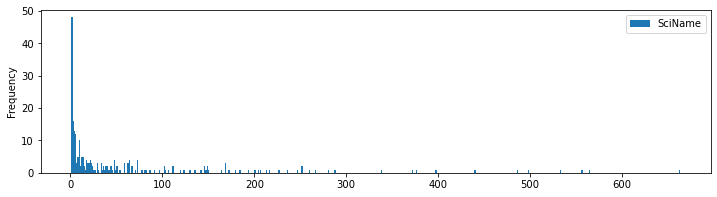

In [ ]:
df_count_F_SP.plot.hist(figsize=(12,3), bins=500,);

In [ ]:
print('Family == 1 Sps : ', df_count_F_SP.query('SciName==1').__len__())
print('Family <= 3 Sps : ', df_count_F_SP.query('SciName<3').__len__())
print('Family == 1 Sps : ')
df_count_F_SP.query('SciName==1').index.values

Family == 1 Sps :  34
Family <= 3 Sps :  48
Family == 1 Sps : 


array(['Notiomystidae', 'Eupetidae', 'Peucedramidae', 'Pedionomidae',
       'Panuridae', 'Eurypygidae', 'Hypocoliidae', 'Balaenicipitidae',
       'Ibidorhynchidae', 'Donacobiidae', 'Nesospingidae', 'Zeledoniidae',
       'Ifritidae', 'Mohoidae', 'Leptosomidae', 'Opisthocomidae',
       'Pityriasidae', 'Eulacestomatidae', 'Pluvianellidae',
       'Urocynchramidae', 'Tichodromidae', 'Steatornithidae',
       'Dromadidae', 'Scopidae', 'Platylophidae', 'Sagittariidae',
       'Sapayoidae', 'Rhynochetidae', 'Rhodinocichlidae', 'Rhagologidae',
       'Anseranatidae', 'Elachuridae', 'Pluvianidae', 'Dulidae'],
      dtype=object)

#### by Family

In [72]:
df_F_static = df_jpg100.groupby(['Family']).Size.agg(['count', 'median','mean']).sort_values(by=['count','Family'])
df_F_static


,count,median,mean
Family,,,
Mohoidae,1,137.470,137.470000
Modulatricidae,10,164.695,306.935000
Melampittidae,20,183.290,220.772500
Rhagologidae,34,178.670,200.931471
Elachuridae,37,184.810,233.748108
...,...,...,...
Thraupidae,36373,175.950,190.222471
Tyrannidae,44608,162.555,178.796813
Trochilidae,46872,148.950,166.253527


In [73]:
df_F_static.describe()

,count,median,mean
count,249.000000,249.000000,249.000000
mean,4848.072289,184.666466,203.269698
std,12769.161461,29.868424,33.282547
min,1.000000,69.860000,100.462590
25%,248.000000,169.630000,185.676734
50%,1140.000000,183.520000,202.314500
75%,4216.000000,201.410000,218.271565
max,166467.000000,272.570000,372.413254


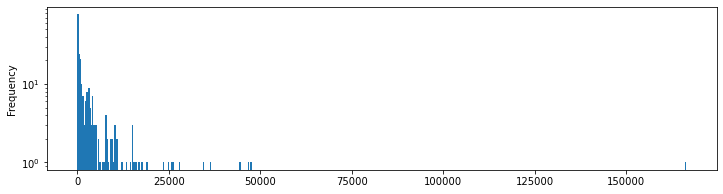

In [64]:
print("Sample Size by 'Family'")
df_F_static['count'].plot.hist(figsize=(12,3), bins=500, logy=True);


#### By Sp

In [15]:
df_Sp_static = df_jpg100.groupby(['Family','SciName']).Size.agg(['count', 'median','mean']).sort_values(by=['count','SciName'])
df_Sp_static

count  median        mean
Family         SciName                                             
Accipitridae   Accipiter_butleri_0            1   72.93   72.930000
               Accipiter_toussenelii_2        1  210.11  210.110000
Acrocephalidae Acrocephalus_baeticatus_1      1  153.97  153.970000
               Acrocephalus_palustris_2       1  153.97  153.970000
               Acrocephalus_scirpaceus_6      1  153.97  153.970000
...                                         ...     ...         ...
Accipitridae   Buteo_buteo_57              9890   92.93  135.049285
               Buteo_lineatus_0            9949  175.67  198.188995
               Milvus_milvus_3             9949   89.83  122.106900
               Buteo_lagopus_0             9959  101.24  133.314018
               Buteo_buteo_55              9967  115.75  152.541630

[16403 rows x 3 columns]

In [75]:
df_Sp_static.describe()

,count,median,mean
count,16403.000000,16403.000000,16403.000000
mean,73.594464,178.597747,194.860806
std,235.491646,67.525278,75.516391
min,1.000000,6.940000,6.940000
25%,18.000000,154.170000,164.547378
50%,83.000000,177.325000,187.847900
75%,100.000000,200.610000,214.933875
max,9967.000000,2344.860000,2121.200000


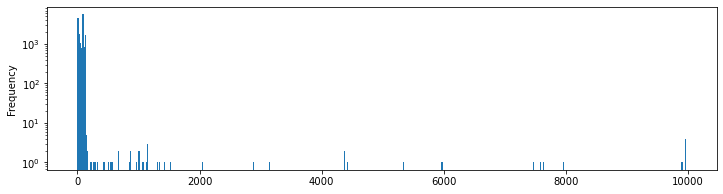

In [60]:

df_Sp_static['count'].plot.hist(figsize=(12,3), bins=500, logy=True);

In [123]:
print('Sample Size == 1 : ', df_Sp_static.query('count==1').__len__())
print('Sample Size <= 3 : ', df_Sp_static.query('count<3').__len__())
df_Sp_static.query('count==1')

Sample Size == 1 :  466
Sample Size <= 3 :  827


count  median    mean
Family         SciName                                          
Accipitridae   Accipiter_butleri_0             1   72.93   72.93
               Accipiter_toussenelii_2         1  210.11  210.11
Acrocephalidae Acrocephalus_baeticatus_1       1  153.97  153.97
               Acrocephalus_palustris_2        1  153.97  153.97
               Acrocephalus_scirpaceus_6       1  153.97  153.97
...                                          ...     ...     ...
Picidae        Yungipicus_ramsayi_0            1   34.45   34.45
Tyrannidae     Zimmerius_parvus_1              1  288.10  288.10
               Zimmerius_vilissimus_1          1  288.10  288.10
               Zimmerius_viridiflavus_3        1  156.58  156.58
Zosteropidae   Zosterops_conspicillatus_2      1  195.68  195.68

[466 rows x 3 columns]

## 檔案大小統計
- 小檔案
    - 主要分布在那些科
    - 那些物種類群可能檔案過小?
- ~~大檔案~~
    - 主要分布在那些科

In [124]:
df_F_static.query('median<10')

,count,median,mean
Family,,,


In [128]:
print('Check sp which almost small size(10kb):')
df_Sp_static.query('median<10')

Check sp which almost small size(10kb):


count  median  mean
Family      SciName                                  
Psittacidae Cyanopsitta_spixii_0      1    6.94  6.94
Apodidae    Apus_affinis_4           10    8.94  9.30
            Apus_apus_28             10    8.94  9.30
            Apus_nipalensis_1        10    8.94  9.30

- Cyanopsitta_spixii : Spix's macaw((斯皮克斯金剛鸚鵡))
- Apus_affinis : Little swift(小白腰雨燕)
- Apus_apus : Common swift (普通樓燕)
- Apus_nipalensis : House swift (小雨燕)

# Establish top100 file list 
- top 100 by ebird user rating  
    - 'Average Community Rating', 'Number of Ratings' in csv file by Family

### Select top 100 based on ebird user rating 
- Find out sps which sample size has more than 100
    - Splt data to sample size 'under 100' and 'over 100'
- Load ebrd meta data depend on 'Family/ Sp'
- Filter top 100 based on  'Average Community Rating', 'Number of Ratings'
- 

In [229]:
df_ebird = pd.read_csv('meta/jpg100_1M.csv', index_col=0)
df_Sp_count = df_ebird.groupby(['Family','SciName']).Size.agg(['count', 'median','mean']).sort_values(by=['count','SciName'])

df_under100 = df_Sp_count.query('count<=100').reset_index()
df_over100 = df_Sp_count.query('count>100').reset_index()
# del df_Sp_static
df_over100

,Family,SciName,count,median,mean
0,Accipitridae,Accipiter_gundlachi_0,101,81.02,125.776040
1,Apodidae,Aerodramus_fuciphagus_0,101,84.92,137.103960
2,Tyrannidae,Alectrurus_tricolor_0,101,122.80,134.882475
3,Tyrannidae,Anairetes_parulus_0,101,155.62,203.687624
4,Tyrannidae,Arundinicola_leucocephala_0,101,132.22,139.098218
...,...,...,...,...,...
2588,Accipitridae,Buteo_buteo_57,9890,92.93,135.049285
2589,Accipitridae,Buteo_lineatus_0,9949,175.67,198.188995
2590,Accipitridae,Milvus_milvus_3,9949,89.83,122.106900
2591,Accipitridae,Buteo_lagopus_0,9959,101.24,133.314018


In [230]:
df_ebird_under100 = df_ebird.merge(df_under100.SciName, on='SciName')
print(len(df_ebird_under100))
df_ebird_over100 = df_ebird.merge(df_over100.SciName, on='SciName')
print(len(df_ebird_over100))
df_ebird_over100

761965
445205


,Family,SciName,ML Catalog Number,Filename,Size
0,Acanthisittidae,Xenicus_gilviventris_0,31799071,Xenicus_gilviventris_0_31799071,149.46
1,Acanthisittidae,Xenicus_gilviventris_0,34962931,Xenicus_gilviventris_0_34962931,299.64
2,Acanthisittidae,Xenicus_gilviventris_0,38209091,Xenicus_gilviventris_0_38209091,287.82
3,Acanthisittidae,Xenicus_gilviventris_0,38209131,Xenicus_gilviventris_0_38209131,259.53
4,Acanthisittidae,Xenicus_gilviventris_0,39313841,Xenicus_gilviventris_0_39313841,260.45
...,...,...,...,...,...
445200,Tyrannidae,Zimmerius_petersi_0,248304031,Zimmerius_petersi_0_248304031,159.96
445201,Tyrannidae,Zimmerius_petersi_0,249152611,Zimmerius_petersi_0_249152611,263.61
445202,Tyrannidae,Zimmerius_petersi_0,256570271,Zimmerius_petersi_0_256570271,141.29
445203,Tyrannidae,Zimmerius_petersi_0,263628231,Zimmerius_petersi_0_263628231,189.53


In [28]:
dir_csv = Path('downloaded/csv')

# files_csv = [path for path in dir_csv.glob('*.csv')]
# files_csv 

In [242]:
def get_top(df:pd.DataFrame, top_limit:int= 100)->pd.DataFrame: 
    df.sort_values(['Average Community Rating', 'Number of Ratings'], ascending=False, inplace=True)
    mlcns = df.iloc[:top_limit]['ML Catalog Number'].values
    return mlcns


In [248]:
top_mlcns = {}

for idx, (i, rows) in enumerate(df_over100.iterrows()) :
    # if idx==10: break
    family, sp, *_ = rows
    
    csv_path = dir_csv.joinpath(family, sp + '.csv')
    df_csv = pd.read_csv(csv_path)[['Scientific Name', 'ML Catalog Number', 'Average Community Rating', 'Number of Ratings']]
    mlcns = get_top(df_csv, top_limit=100)
    top_mlcns[sp] = mlcns 
    print(idx, len(top_mlcns), family, sp, end='\r')

print(len(top_mlcns))
    

2593 2593 Accipitridae Buteo_buteo_5500racinus_00_0us_0e_00nidae Tyrannus_niveigularis_0119 Tyrannidae Elaenia_frantzii_0 Columbidae Streptopelia_picturata_0429 Phalacrocoracidae Phalacrocorax_aristotelis_2555 Caprimulgidae Gactornis_enarratus_0 Spatula_discors_2 Diomedea_epomophora_2Trochilidae Amazilia_hoffmanni_0 Phalacrocoracidae Phalacrocorax_nigrogularis_0901 Charadriidae Phegornis_mitchellii_01022 Cuculidae Coccyzus_merlini_21178 Cracidae Ortalis_columbiana_0Pipile_pipile_81265 Otididae Eupodotis_afra_1 Trochilidae Metallura_tyrianthina_0 Diomedeidae Diomedea_epomophora_0Ciconia_nigra_0 Anatidae Anas_crecca_1 Trochilidae Selasphorus_sasin_2 Spheniscus_demersus_0Branta_hutchinsii_0 Furnariidae Phacellodomus_rufifrons_0 Casuariidae Dromaius_novaehollandiae_0 Trochilidae Patagona_gigas_0Puffinus_opisthomelas_02572 Accipitridae Gyps_rueppelli_02589 Accipitridae Buteo_buteo_57


In [310]:
df_top_mlcns = (pd.DataFrame.from_dict(top_mlcns, orient='index')
                .stack().rename('ML Catalog Number')
                .reset_index(level=1, drop=True).rename_axis('SciName')
                .reset_index()
                )
print(len(df_top_mlcns))
df_top_mlcns

259300


,SciName,ML Catalog Number
0,Accipiter_gundlachi_0,221808521
1,Accipiter_gundlachi_0,100733801
2,Accipiter_gundlachi_0,56173931
3,Accipiter_gundlachi_0,168527021
4,Accipiter_gundlachi_0,100733781
...,...,...
259295,Buteo_buteo_55,247686881
259296,Buteo_buteo_55,245903911
259297,Buteo_buteo_55,245642041
259298,Buteo_buteo_55,245642031


In [293]:
df_top_mlcns[df_top_mlcns.duplicated(subset='ML Catalog Number',keep=False)].sort_values(by='ML Catalog Number')

,Sciname,ML Catalog Number
127498,Himantopus_himantopus_10,702399
127598,Himantopus_mexicanus_3,702399
114299,Coeligena_torquata_2,702475
114199,Coeligena_coeligena_5,702475
49295,Coeligena_prunellei_0,702476
...,...,...
50084,Pipile_cujubi_0,264469571
50083,Pipile_cujubi_0,264469881
50183,Pipile_pipile_4,264469881
50082,Pipile_cujubi_0,264469901


In [336]:
print(len(df_ebird_over100))
print(len(df_top_mlcns))

df_ebird_over100_filtered = (df_ebird_over100
                             .merge(df_top_mlcns, 
                                    on=['SciName', 'ML Catalog Number'], how='inner')
                            #  .iloc[:,:-1]
                             )
df_ebird_over100_filtered

445205
259300


,Family,SciName,ML Catalog Number,Filename,Size
0,Acanthisittidae,Xenicus_gilviventris_0,31799071,Xenicus_gilviventris_0_31799071,149.46
1,Acanthisittidae,Xenicus_gilviventris_0,34962931,Xenicus_gilviventris_0_34962931,299.64
2,Acanthisittidae,Xenicus_gilviventris_0,38209091,Xenicus_gilviventris_0_38209091,287.82
3,Acanthisittidae,Xenicus_gilviventris_0,38209131,Xenicus_gilviventris_0_38209131,259.53
4,Acanthisittidae,Xenicus_gilviventris_0,39313841,Xenicus_gilviventris_0_39313841,260.45
...,...,...,...,...,...
257998,Tyrannidae,Zimmerius_petersi_0,248304031,Zimmerius_petersi_0_248304031,159.96
257999,Tyrannidae,Zimmerius_petersi_0,249152611,Zimmerius_petersi_0_249152611,263.61
258000,Tyrannidae,Zimmerius_petersi_0,256570271,Zimmerius_petersi_0_256570271,141.29
258001,Tyrannidae,Zimmerius_petersi_0,263628231,Zimmerius_petersi_0_263628231,189.53


### Concat Data with sample size under 100 and over 100

In [348]:
df_ebird_filtered = pd.concat([df_ebird_under100, df_ebird_over100_filtered,  ]).sort_values(by=['Family','SciName']).reset_index(drop=True)

print(f'Origunal data size : {len(df_ebird):>9,d}')
print(f'Filtered data size : {len(df_ebird_filtered):>9,d}')


Origunal data size : 1,207,170
Filtered data size : 1,019,968


In [339]:
(df_ebird_filtered[df_ebird_filtered.duplicated(subset='ML Catalog Number', keep=False)]
 .sort_values(by='ML Catalog Number')
 )

,Family,SciName,ML Catalog Number,Filename,Size
488095,Muscicapidae,Eumyias_indigo_0,701695,Eumyias_indigo_0_701695,158.87
488195,Muscicapidae,Eumyias_indigo_1,701695,Eumyias_indigo_1_701695,158.87
145875,Campephagidae,Coracina_striata_1,701703,Coracina_striata_1_701703,193.01
145775,Campephagidae,Coracina_striata_0,701703,Coracina_striata_0_701703,193.01
136258,Bucerotidae,Horizocerus_hartlaubi_0,701776,Horizocerus_hartlaubi_0_701776,187.97
...,...,...,...,...,...
246516,Cracidae,Pipile_cujubi_0,264469901,Pipile_cujubi_0_264469901,329.60
247117,Cracidae,Pipile_pipile_4,264469901,Pipile_pipile_4_264469901,329.60
627970,Phylloscopidae,Phylloscopus_xanthodryas_2,264482671,Phylloscopus_xanthodryas_2_264482671,188.16
620927,Phylloscopidae,Phylloscopus_borealis_3,264482671,Phylloscopus_borealis_3_264482671,188.16


In [350]:
df_ebird_filtered.to_csv('meta/jpg100_1M_filtered.csv')
df_ebird_filtered

,Family,SciName,ML Catalog Number,Filename,Size
0,Acanthisittidae,Acanthisitta_chloris_0,22413261,Acanthisitta_chloris_0_22413261,61.48
1,Acanthisittidae,Acanthisitta_chloris_0,22413271,Acanthisitta_chloris_0_22413271,68.64
2,Acanthisittidae,Acanthisitta_chloris_0,30352591,Acanthisitta_chloris_0_30352591,132.18
3,Acanthisittidae,Acanthisitta_chloris_0,40629251,Acanthisitta_chloris_0_40629251,176.57
4,Acanthisittidae,Acanthisitta_chloris_0,41060091,Acanthisitta_chloris_0_41060091,165.23
...,...,...,...,...,...
1019963,Zosteropidae,Zosterornis_whiteheadi_0,219727771,Zosterornis_whiteheadi_0_219727771,310.95
1019964,Zosteropidae,Zosterornis_whiteheadi_0,219727781,Zosterornis_whiteheadi_0_219727781,349.39
1019965,Zosteropidae,Zosterornis_whiteheadi_0,219727791,Zosterornis_whiteheadi_0_219727791,368.17
1019966,Zosteropidae,Zosterornis_whiteheadi_0,219727801,Zosterornis_whiteheadi_0_219727801,324.02


In [321]:
df_Sp_count  = df_ebird_filtered.groupby(['Family','SciName']).SciName.count().rename('Count').reset_index()
df_Sp_count

,Family,SciName,Count
0,Acanthisittidae,Acanthisitta_chloris_0,100
1,Acanthisittidae,Xenicus_gilviventris_0,100
2,Acanthizidae,Acanthiza_apicalis_0,100
3,Acanthizidae,Acanthiza_chrysorrhoa_0,100
4,Acanthizidae,Acanthiza_cinerea_0,9
...,...,...,...
16398,Zosteropidae,Zosterornis_hypogrammicus_0,10
16399,Zosteropidae,Zosterornis_latistriatus_0,3
16400,Zosteropidae,Zosterornis_nigrorum_0,4
16401,Zosteropidae,Zosterornis_striatus_0,8


In [322]:
df_Sp_count.describe()

,Count
count,16403.000000
mean,62.181796
std,40.238461
min,1.000000
25%,18.000000
50%,83.000000
75%,100.000000
max,100.000000


# Check jpg_top100/ files

In [5]:

df_jpg100 = pd.read_csv('meta/jpg_top100.txt',
                        usecols=[4,8],
                        names=['Size', 'Path'],
                        sep=' ',
                        header=None 
                        )
# df_jpg100 = df_jpg100.query('~Path.str.contains("checkpoint")').reset_index(drop=True)
df_jpg100

,Size,Path
0,162891,downloaded/jpg_top100/Acanthisittidae/Acanthis...
1,296210,downloaded/jpg_top100/Acanthisittidae/Acanthis...
2,124934,downloaded/jpg_top100/Acanthisittidae/Acanthis...
3,294646,downloaded/jpg_top100/Acanthisittidae/Xenicus_...
4,230262,downloaded/jpg_top100/Acanthisittidae/Xenicus_...
...,...,...
1019966,211764,downloaded/jpg_top100/Zosteropidae/Zosterops_m...
1019967,109798,downloaded/jpg_top100/Zosteropidae/Zosterops_l...
1019968,206092,downloaded/jpg_top100/Zosteropidae/Zosterops_l...
1019969,165973,downloaded/jpg_top100/Zosteropidae/Zosterops_s...


In [6]:
df_jpg100.query('Path.str.contains("checkpoint")').reset_index(drop=True)

,Size,Path
0,253680,downloaded/jpg_top100/Gruidae/.ipynb_checkpoin...
1,96476,downloaded/jpg_top100/Gruidae/.ipynb_checkpoin...
2,231897,downloaded/jpg_top100/Gruidae/.ipynb_checkpoin...


In [8]:
df_jpg100.query('Path.str.contains("checkpoint")').reset_index(drop=True).Path.values

array(['downloaded/jpg_top100/Gruidae/.ipynb_checkpoints/Grus_nigricollis_0_84827551-checkpoint.jpg',
       'downloaded/jpg_top100/Gruidae/.ipynb_checkpoints/Grus_nigricollis_0_204452841-checkpoint.jpg',
       'downloaded/jpg_top100/Gruidae/.ipynb_checkpoints/Leucogeranus_leucogeranus_0_23894091-checkpoint.jpg'],
      dtype=object)

- 多出來的3筆資料為 .ipynb_checkpoints/ 內的檔案
    - 'downloaded/jpg_top100/Gruidae/.ipynb_checkpoints/Grus_nigricollis_0_84827551-checkpoint.jpg'
    - 'downloaded/jpg_top100/Gruidae/.ipynb_checkpoints/Grus_nigricollis_0_204452841-checkpoint.jpg'
    - 'downloaded/jpg_top100/Gruidae/.ipynb_checkpoints/Leucogeranus_leucogeranus_0_23894091-checkpoint.jpg'